[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IshmaGurca/AtomicNite/blob/main/notebooks/VoG_ActiveLearning.ipynb)

# VOG AS UNCERTAINTY MEASURE IN ACTIVE LEARNING

In active learning we are trying to re-train our model on new labeled data that we consider as "usefull". 
Therefore we use a measure of uncertainty in our prediction to pick the examples on our pool of not used data. 
By labeling such uncertain data points and re-train our model we can in general speed up the learning process.

Commonly used uncertainty measures are:

- Maximum Softmax Probability
- Difference of highest and second highest Softmax Probability
- Monte-Carlo Dropout or Test-Time Dropout

In this notebook we implement the VOG as an alternative uncertainty measurement

In [1]:
!pip install torch torchvision skorch modAL

In [2]:
### Import
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy 

from typing import Tuple

from sklearn.base import BaseEstimator

import torch
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
import torchvision
import torch.nn.functional as F

from skorch import NeuralNetClassifier
from skorch.callbacks import Callback


from modAL.models import ActiveLearner
from modAL.utils.data import modALinput
from modAL.utils.selection import multi_argmax, shuffled_argmax

In [3]:
### Set random set for pytorch model
seed = 0
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
### Load MNIST dataset

DATA_FOLDER = '../data'

mnist_train = torchvision.datasets.MNIST(DATA_FOLDER, download=True,train=True,
    transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
mnist_test = torchvision.datasets.MNIST(DATA_FOLDER, download=True,train=False,
    transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [5]:
### Skew the MNIST dataset
DATA_SIZE = 40000
TRAIN_TEST_SPLIT = 0.8
INITIAL_POOL_SIZE = 1000

mnist_train_subset= Subset(mnist_train,list(WeightedRandomSampler((mnist_train.targets != 5) *0.95 + (mnist_train.targets == 5) *0.05, DATA_SIZE, replacement=False)))
mnist_test_subset = Subset(mnist_test,list(WeightedRandomSampler((mnist_test.targets == 5) *0.99 + (mnist_test.targets != 5) *0.01, 100, replacement=False)))

In [6]:
dataloader = DataLoader(mnist_train_subset, shuffle=True, batch_size=DATA_SIZE)

X, y = next(iter(dataloader))

# read training data
test_idx = int(TRAIN_TEST_SPLIT*DATA_SIZE)
X_train, X_test, y_train, y_test = X[:test_idx], X[test_idx:], y[:test_idx], y[test_idx:]
X_train = X_train.reshape(test_idx, 1, 28, 28)
X_test = X_test.reshape(DATA_SIZE - test_idx, 1, 28, 28)

# assemble initial data
initial_idx = np.random.choice(range(len(X_train)), size=INITIAL_POOL_SIZE, replace=False)
X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0)[:test_idx]
y_pool = np.delete(y_train, initial_idx, axis=0)[:test_idx]

In [7]:
### Network Definition

class EmbNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = 20
        self.lin = torch.nn.Linear(28*28,self.hidden)
        self.bn = torch.nn.BatchNorm1d(self.hidden)

    def forward(self,x):
        x = x.reshape(x.shape[0],28*28)
        x = self.lin(x)
        #x = torch.sigmoid(x)
        x = self.bn(x)
        return x

class Classification_Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.emb_hidden = 20
        self.hidden = 20
        self.lin1 = torch.nn.Linear(self.emb_hidden,self.hidden)
        self.lin2a = torch.nn.Linear(self.hidden,self.hidden)
        self.lin2b = torch.nn.Linear(self.hidden,10)
         
    def  forward(self,x):
        x = self.lin1(x)
        x = torch.relu(x)
        x = self.lin2a(x)
        x = torch.relu(x)
        x = self.lin2b(x)
        return x

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.emb_net = EmbNet()
        self.net = Classification_Net()

    def forward(self,x):
        x_emb = self.emb_net(x)
        x = self.net(x_emb)
        return x

network = Net()

In [8]:
# create the classifier
device = "cpu"
classifier = NeuralNetClassifier(Net(),
                                 criterion=torch.nn.CrossEntropyLoss,
                                 optimizer=torch.optim.Adam,
                                 train_split=None,
                                 verbose=1,
                                 device=device)

In [9]:
# initialize ActiveLearner
learner = ActiveLearner(
    estimator=classifier,
    X_training=X_initial.numpy(), y_training=y_initial.numpy(),
)

acc = np.sum(learner.predict(X_test) == y_test.numpy())/len(y_test)
print('Accuracy: {:.2f}'.format(acc))

  epoch    train_loss     dur
-------  ------------  ------
      1        2.0124  0.0980
      2        1.1998  0.0410
      3        0.5816  0.0420
      4        0.3337  0.0420
      5        0.2061  0.0410
      6        0.1251  0.0410
      7        0.0839  0.0400
      8        0.0588  0.0410
      9        0.0439  0.0410
     10        0.0268  0.0430
Accuracy: 0.86


Query no. 1
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.4282  0.0460
      2        0.2276  0.0470
      3        0.1903  0.0510
      4        0.1037  0.0490
      5        0.0712  0.0490
      6        0.0468  0.0500
      7        0.0343  0.0501
      8        0.0231  0.0480
      9        0.0170  0.0510
     10        0.0133  0.0490


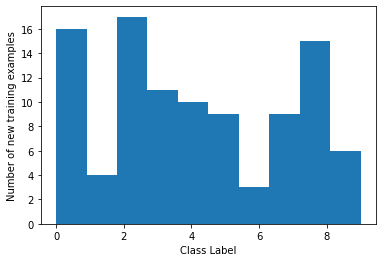

Accuracy: 0.87
Query no. 2
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.3181  0.0520
      2        0.3151  0.0570
      3        0.1585  0.0530
      4        0.0944  0.0510
      5        0.0585  0.0480
      6        0.0368  0.0520
      7        0.0237  0.0520
      8        0.0175  0.0530
      9        0.0131  0.0520
     10        0.0108  0.0611


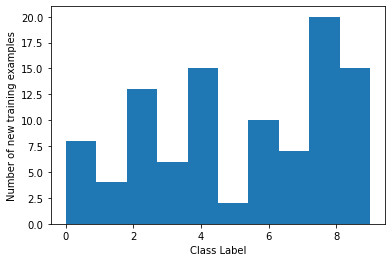

Accuracy: 0.88
Query no. 3
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.3279  0.0540
      2        0.4061  0.0590
      3        0.2452  0.0550
      4        0.1531  0.0569
      5        0.0949  0.0550
      6        0.0736  0.0560
      7        0.0547  0.0550
      8        0.0509  0.0550
      9        0.0294  0.0570
     10        0.0174  0.0550


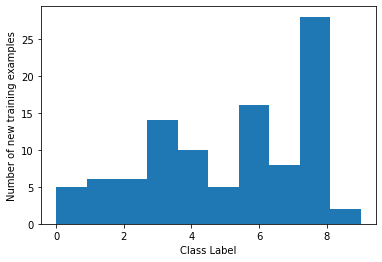

Accuracy: 0.88
Query no. 4
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.2572  0.0620
      2        0.2379  0.0580
      3        0.2400  0.0606
      4        0.1708  0.0653
      5        0.0875  0.0601
      6        0.0696  0.0596
      7        0.0461  0.0585
      8        0.0230  0.0580
      9        0.0182  0.0591
     10        0.0099  0.0580


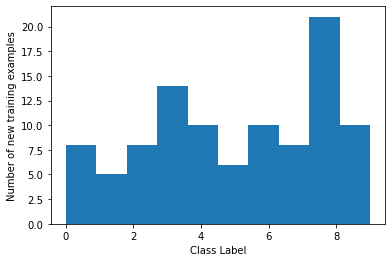

Accuracy: 0.89
Query no. 5
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.3277  0.0660
      2        0.2924  0.0680
      3        0.2183  0.0650
      4        0.1564  0.0640
      5        0.1346  0.0660
      6        0.1164  0.0630
      7        0.0814  0.0630
      8        0.0588  0.0751
      9        0.0431  0.0650
     10        0.0460  0.0660


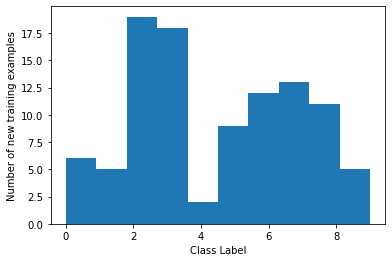

Accuracy: 0.89
Query no. 6
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.2789  0.0651
      2        0.2582  0.0675
      3        0.2051  0.0650
      4        0.1868  0.0650
      5        0.1370  0.0660
      6        0.0987  0.0690
      7        0.1022  0.0670
      8        0.0993  0.0710
      9        0.0809  0.0672
     10        0.0730  0.0650


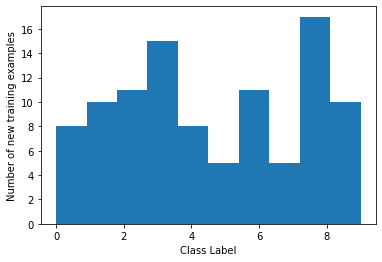

Accuracy: 0.89
Query no. 7
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.2237  0.0700
      2        0.2925  0.0690
      3        0.2221  0.0711
      4        0.1505  0.0686
      5        0.1260  0.0711
      6        0.1165  0.0690
      7        0.1041  0.0700
      8        0.0772  0.0730
      9        0.0675  0.0710
     10        0.0438  0.0707


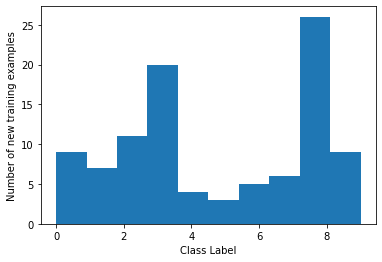

Accuracy: 0.90
Query no. 8
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.2825  0.0760
      2        0.3191  0.0760
      3        0.2764  0.0780
      4        0.1660  0.0763
      5        0.1122  0.0740
      6        0.0694  0.0740
      7        0.0686  0.0720
      8        0.0511  0.0760
      9        0.0505  0.0810
     10        0.0326  0.0798


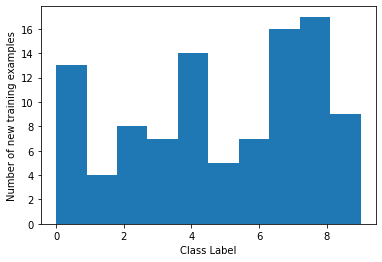

Accuracy: 0.90
Query no. 9
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.2250  0.0770
      2        0.2508  0.0770
      3        0.1989  0.0780
      4        0.1687  0.0780
      5        0.1373  0.0760
      6        0.1340  0.0800
      7        0.1332  0.0765
      8        0.1066  0.0830
      9        0.0697  0.0810
     10        0.0549  0.0777


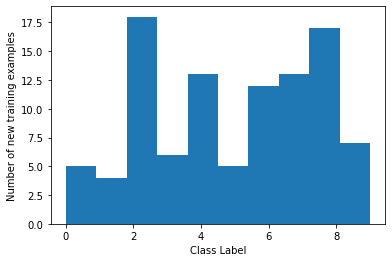

Accuracy: 0.91
Query no. 10
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.2106  0.0479
      2        0.2306  0.0520
      3        0.1378  0.0690
      4        0.1501  0.0730
      5        0.1259  0.0530
      6        0.1172  0.0710
      7        0.0909  0.0670
      8        0.0880  0.0500
      9        0.0799  0.0767
     10        0.0871  0.0800


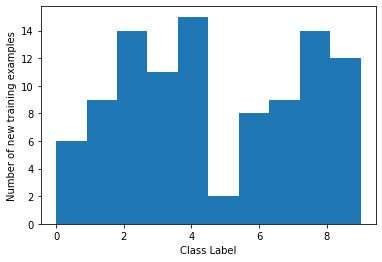

Accuracy: 0.91


In [10]:
# the active learning loop
n_queries = 10
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(X_pool.numpy(), n_instances=100)
    learner.teach(
        X=X_pool[query_idx].numpy(), y=y_pool[query_idx].numpy(), only_new=False,
    )
    plt.hist(y_pool[query_idx].numpy())
    plt.ylabel('Number of new training examples')
    plt.xlabel('Class Label')
    plt.show()
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    acc = np.sum(learner.predict(X_test) == y_test.numpy())/len(y_test)
    print('Accuracy: {:.2f}'.format(acc))

In [11]:
class cb_weight_save(Callback):
    def __init__(self):
        self.saved_models = []
    def on_epoch_end(self, net, dataset_train, dataset_valid, **kwargs):
        self.saved_models.append(deepcopy(net.module.state_dict()))

classifier = NeuralNetClassifier(Net(),
                                 criterion=torch.nn.CrossEntropyLoss,
                                 optimizer=torch.optim.Adam,
                                 train_split=None,
                                 verbose=1,
                                 device=device,
                                 callbacks=[cb_weight_save()])

In [12]:
### Define Variance of Gradient
def VoG(x,classifier):
    
    saved_models = classifier.estimator.callbacks[0].saved_models
    x = torch.Tensor(x)
    x.requires_grad = True
    grads = []
    for net_dict in saved_models:
        classifier.estimator.module.load_state_dict(net_dict)
        y_test_hat =  classifier.estimator.module(x)
        m,_ = torch.max(y_test_hat,axis=-1)
        m.backward(gradient=torch.ones(m.size()))
        grad = deepcopy(x.grad.detach())
        grads.append(grad)
        x.grad.zero_()

    grad_stack = torch.stack(grads)
    grad_stack = grad_stack.reshape(grad_stack.shape[0],grad_stack.shape[1],28*28).transpose(1,0)
    return torch.mean(torch.mean((grad_stack- torch.mean(grad_stack,axis=1, keepdim=True))**2,axis=1),axis=-1)

In [13]:
def vog_sampling(classifier: BaseEstimator, X: modALinput,
                         n_instances: int = 1, random_tie_break: bool = False,
                         **uncertainty_measure_kwargs) -> Tuple[np.ndarray, modALinput]:

    uncertainty =  VoG(X,classifier)

    if not random_tie_break:
        query_idx = multi_argmax(uncertainty, n_instances=n_instances)
    else:
        query_idx = shuffled_argmax(uncertainty, n_instances=n_instances)

    return query_idx, X[query_idx]

In [14]:
# initialize ActiveLearner
learner = ActiveLearner(
    estimator=classifier,
    X_training=X_initial.numpy(), y_training=y_initial.numpy(),
    query_strategy=vog_sampling
)

acc = np.sum(learner.predict(X_test) == y_test.numpy())/len(y_test)
print('Accuracy: {:.2f}'.format(acc))

  epoch    train_loss     dur
-------  ------------  ------
      1        2.0498  0.0300
      2        1.2535  0.0260
      3        0.6403  0.0280
      4        0.3778  0.0290
      5        0.2400  0.0320
      6        0.1621  0.0260
      7        0.1188  0.0280
      8        0.0718  0.0270
      9        0.0541  0.0250
     10        0.0398  0.0259
Accuracy: 0.86


Query no. 1
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.3960  0.0330
      2        0.2421  0.0310
      3        0.1691  0.0400
      4        0.1068  0.0350
      5        0.0742  0.0330
      6        0.0509  0.0440
      7        0.0375  0.0380
      8        0.0290  0.0320
      9        0.0222  0.0280
     10        0.0176  0.0353


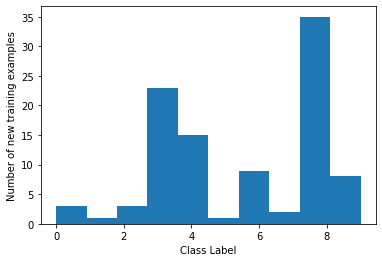

Accuracy: 0.86
Query no. 2
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.4378  0.0470
      2        0.2803  0.0450
      3        0.1550  0.0310
      4        0.0965  0.0310
      5        0.0751  0.0360
      6        0.0533  0.0450
      7        0.0401  0.0368
      8        0.0292  0.0340
      9        0.0226  0.0330
     10        0.0183  0.0310


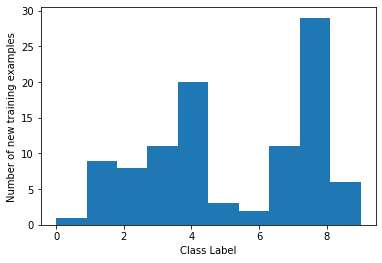

Accuracy: 0.87
Query no. 3
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.3697  0.0624
      2        0.5367  0.0350
      3        0.2369  0.0380
      4        0.1590  0.0340
      5        0.1051  0.0350
      6        0.0669  0.0330
      7        0.0512  0.0350
      8        0.0394  0.0340
      9        0.0316  0.0430
     10        0.0258  0.0330


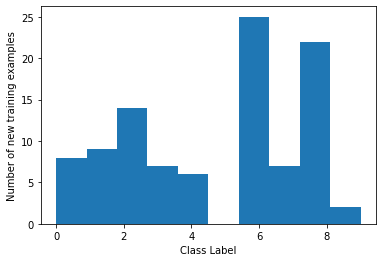

Accuracy: 0.87
Query no. 4
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.3790  0.0560
      2        0.3653  0.0537
      3        0.2469  0.0364
      4        0.1675  0.0420
      5        0.1051  0.0380
      6        0.0766  0.0360
      7        0.0434  0.0350
      8        0.0355  0.0360
      9        0.0249  0.0460
     10        0.0193  0.0420


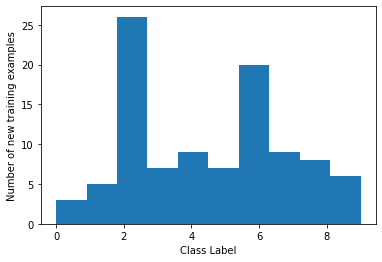

Accuracy: 0.88
Query no. 5
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.2708  0.0659
      2        0.2775  0.0420
      3        0.1893  0.0410
      4        0.1266  0.0400
      5        0.0754  0.0390
      6        0.0578  0.0450
      7        0.0560  0.0590
      8        0.0603  0.0620
      9        0.0459  0.0470
     10        0.0267  0.0525


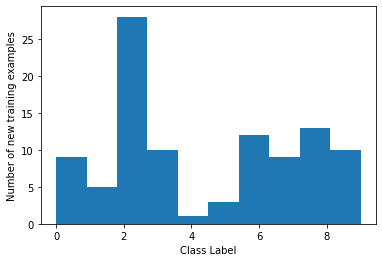

Accuracy: 0.89
Query no. 6
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.2688  0.0854
      2        0.2581  0.0580
      3        0.1832  0.0430
      4        0.0931  0.0410
      5        0.0587  0.0420
      6        0.0597  0.0410
      7        0.0810  0.0440
      8        0.1045  0.0440
      9        0.0763  0.0630
     10        0.0749  0.0574


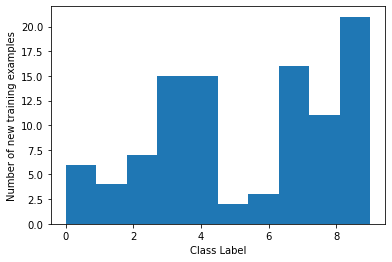

Accuracy: 0.89
Query no. 7
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.2452  0.0680
      2        0.2669  0.0450
      3        0.2500  0.0570
      4        0.1386  0.0420
      5        0.0818  0.0430
      6        0.0494  0.0580
      7        0.0356  0.0560
      8        0.0348  0.0450
      9        0.0295  0.0490
     10        0.0269  0.0490


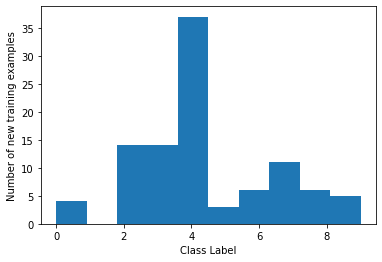

Accuracy: 0.89
Query no. 8
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.2078  0.0720
      2        0.3349  0.0857
      3        0.2040  0.0500
      4        0.1162  0.0530
      5        0.0763  0.0480
      6        0.0668  0.0710
      7        0.0430  0.0530
      8        0.0375  0.0590
      9        0.0267  0.0570
     10        0.0176  0.0655


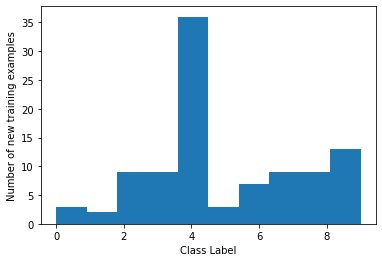

Accuracy: 0.90
Query no. 9
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.3091  0.0772
      2        0.3306  0.0740
      3        0.2021  0.0665
      4        0.1124  0.0540
      5        0.0604  0.0490
      6        0.0332  0.0630
      7        0.0210  0.0630
      8        0.0139  0.0486
      9        0.0085  0.0700
     10        0.0068  0.0500


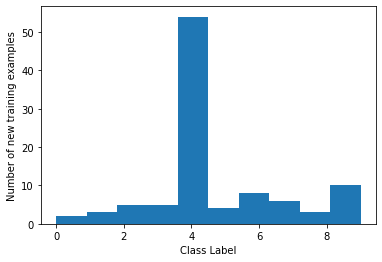

Accuracy: 0.90
Query no. 10
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.2611  0.0926
      2        0.3590  0.0700
      3        0.2099  0.0520
      4        0.1189  0.0540
      5        0.0768  0.0690
      6        0.0371  0.0540
      7        0.0299  0.0660
      8        0.0227  0.0714
      9        0.0247  0.0510
     10        0.0339  0.0528


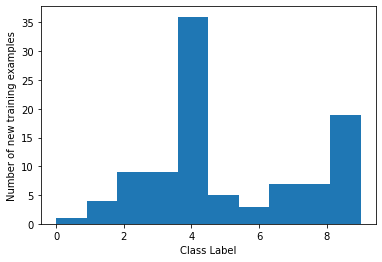

Accuracy: 0.90


In [15]:
# the active learning loop
n_queries = 10
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    if isinstance(X_pool,np.ndarray) == False:
        X_pool = X_pool.detach().numpy()
    query_idx, query_instance = learner.query(X_pool, n_instances=100)
    learner.teach(
        X=X_pool[query_idx], y=y_pool[query_idx].numpy(), only_new=False,
    )
    plt.hist(y_pool[query_idx].numpy())
    plt.ylabel('Number of new training examples')
    plt.xlabel('Class Label')
    plt.show()
    
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    acc = np.sum(learner.predict(X_test) == y_test.numpy())/len(y_test)
    print('Accuracy: {:.2f}'.format(acc))